# Neural Network 201
In this example, we will walk through two-input single output neural network model. We will train this model to predict used cars' prices based on two features: age and mileage.

The following contents will be covered:
1. Preprocess the data.
2. Construct multi-input linear model.
3. Vector and matrix operations.
4. Rectified linear unit (ReLU) activation.


## Load Raw Data
Data is from [Used Car Dataset](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data). Data is prepocessed and shuffled. N/As and outliers were taken out. 90% are used for training the model. We'll use the rest 10% samples to evaluate and test the model. 

First, let's load the data as numpy arrays.

In [1]:
import numpy as np
age_train = np.load('age_train.npy')
mileage_train = np.load('mileage_train.npy')
price_train = np.load('price_train.npy')
age_test = np.load('age_test.npy')
mileage_test = np.load('mileage_test.npy')
price_test = np.load('price_test.npy')
print(f"age_train shape: {age_train.shape}")
print(f"mileage_train shape: {mileage_train.shape}")
print(f"price_train shape: {age_train.shape}")
print(f"age_test shape: {age_test.shape}")
print(f"mileage_test shape: {mileage_test.shape}")
print(f"price_test shape: {age_test.shape}")


age_train shape: (268577,)
mileage_train shape: (268577,)
price_train shape: (268577,)
age_test shape: (29842,)
mileage_test shape: (29842,)
price_test shape: (29842,)


## Visualize the Data
Use [matplotlib](https://matplotlib.org/). **Note**: `matplotlib` will auto scale the figure to better fill the space.

[Text(0.5, 0, 'Mileage (miles)'), Text(0, 0.5, 'Price ($)')]

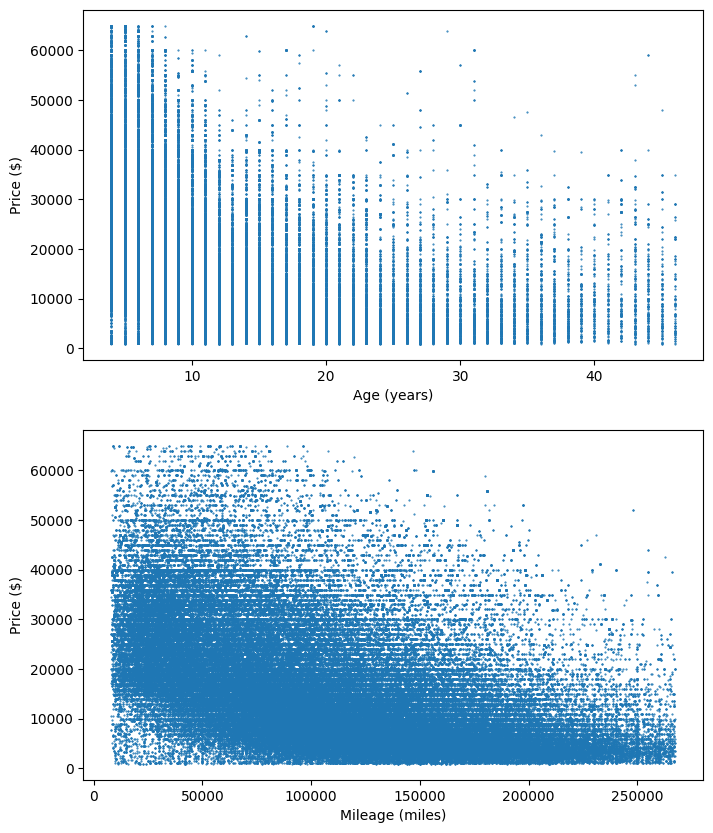

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1)
fig.set_figwidth(8)
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)
axs[0].plot(age_train, price_train, '.', markersize=1)
axs[0].set(xlabel='Age (years)', ylabel='Price ($)')
axs[1] = plt.subplot(2,1,2)
axs[1].plot(mileage_train, price_train, '.', markersize=1)
axs[1].set(xlabel='Mileage (miles)', ylabel='Price ($)')


Visualize raw data in 3D space

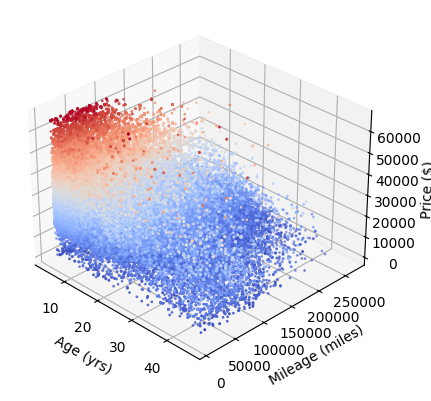

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the data
scatter = ax.scatter3D(age_train, mileage_train, price_train, s=np.ones(price_train.size), c=price_train, cmap='coolwarm') 

ax.set_xlabel('Age (yrs)')
ax.set_ylabel('Mileage (miles)')
ax.set_zlabel('Price ($)')

ax.view_init(elev=30, azim=-45)  # set elevation and azimuth of viewing angle

# colorbar = fig.colorbar(scatter, ax=ax)


## Pre-process the Data
1. Rescale `age`, `mileage` and `price` arrays to avoid large parameters in model. 
2. Stack the rescaled `age` and `mileage` arrays to form a feature matrix, or a 2d-array with shape (M, 2). 
3. Reshape rescaled `price` array to a column vector, or a 2d-array with shape (M, 1).
> M represents number of samples.

(268577, 2) (268577, 1) (29842, 2) (29842, 1)


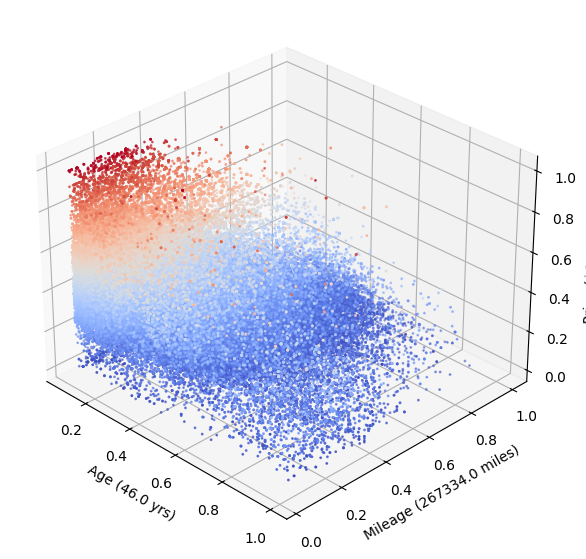

In [11]:
# Rescale
# age_train_rescale = age_train / 10
# mileage_train_rescale = mileage_train / 1e4
# price_train_rescale = price_train / 1e4
# age_test_rescale = age_test / 10
# mileage_test_rescale = mileage_test / 1e4
# price_test_rescale = price_test / 1e4
age_train_rescale = age_train / age_train.max()
mileage_train_rescale = mileage_train / mileage_train.max()
price_train_rescale = price_train / price_train.max()
age_test_rescale = age_test / age_train.max()
mileage_test_rescale = mileage_test / mileage_train.max()
price_test_rescale = price_test / price_train.max()

# Stack features
X_train = np.stack((age_train_rescale, mileage_train_rescale), axis=1)
X_test = np.stack((age_test_rescale, mileage_test_rescale), axis=1)
# Reshape labels
y_train = price_train_rescale.reshape(-1, 1)
y_test = price_test_rescale.reshape(-1, 1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)  # for debug

# Visualize preprocessed data
# fig, axs = plt.subplots(2,1)
# fig.set_figwidth(8)
# fig.set_figheight(10)
# axs[0] = plt.subplot(2,1,1)
# axs[0].plot(X_train[:, 0], y_train, 'b.')
# axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')
# axs[1] = plt.subplot(2,1,2)
# axs[1].plot(X_train[:, 1], y_train, 'b.')
# axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')
fig = plt.figure()
fig.set_figwidth(7)
fig.set_figheight(7)
ax = fig.add_subplot(111, projection='3d')
# Plot the data
scatter = ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train.squeeze(), s=np.ones(y_train.size), c=y_train.squeeze(), cmap='coolwarm') 

ax.set_xlabel(f'Age ({age_train.max()} yrs)')
ax.set_ylabel(f'Mileage ({mileage_train.max()} miles)')
ax.set_zlabel(f'Price (${price_train.max()})')

ax.view_init(elev=30, azim=-45)  # set elevation and azimuth of viewing angle

# colorbar = fig.colorbar(scatter, ax=ax)


## Create an Initial Model
Create a linear model: $\hat{y}=w_1x_1 + w_2x_2 + b$. Initialize three parameters, $w_1$, $w_2$ and $b$ to small values (close to 0).

(268577, 1)


[Text(0.5, 0, 'Mileage (Unit: 267334.0 miles)'),
 Text(0, 0.5, 'Price (Unit: $64997)')]

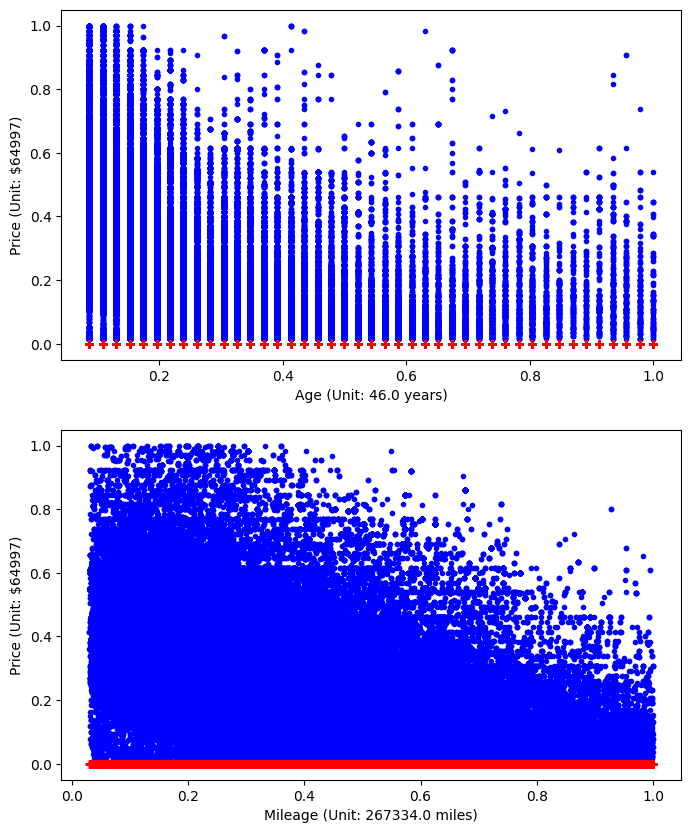

In [17]:
# Define model function
def forward(input, weight, bias):
    """ Model function
    Args:
        input: feature matrix (independent variables), 2d-array with shape (# samples, # features)
        weight: row vector of weights, 2d-array with shape (1, # features)
        bias: scalar
    Returns:
        output: column vector of predictions (dependent variables), 2d-array with shape (# samples, 1)
    """
    output = np.dot(input, weight.T) + bias
    return output

# Initialize model parameters: w1, w2, b
w = np.zeros((1, 2)) + np.random.normal(0, 1e-4, (1, 2)) 
b = 0 + np.random.normal(0, 1e-4)
y_pred = forward(X_train, w, b)
print(y_pred.shape)

# Visualize intial model on two planes
fig, axs = plt.subplots(2,1)
fig.set_figwidth(8)
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)
axs[0].plot(X_train[:, 0], y_train, 'b.')
axs[0].plot(X_train[:, 0], y_pred, 'r+')
axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')
axs[1] = plt.subplot(2,1,2)
axs[1].plot(X_train[:, 1], y_train, 'b.')
axs[1].plot(X_train[:, 1], y_pred, 'r+')
axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')

## Create Loss Function
Use Mean Square Error function to evaluate how bad the model was.

In [18]:
def mse_loss(prediction, target):
    """ Mean Square Error function
    Args:
        prediction: column vector of predictions, 2d-array with shape (# samples, 1)
        target: column vector of ground truths, 2d-array with shape (# samples, 1)
    Returns:
        loss_value: scalar
    """
    loss_value = np.mean(1 / 2 * (prediction - target) ** 2)
    return loss_value

# Evaluate initial model
loss = mse_loss(prediction=y_pred, target=y_train)
print(f"mse loss: {loss}")

mse loss: 0.051396133570597594


## Gradient Descent Optimization

loss @ 1 iteration: 0.051396133570597594
loss @ 2 iteration: 0.04985770787136748
loss @ 3 iteration: 0.048392293433429816
loss @ 4 iteration: 0.04699639553698988
loss @ 5 iteration: 0.04566668678774909
loss @ 6 iteration: 0.044399999105359945
loss @ 7 iteration: 0.04319331609547382
loss @ 8 iteration: 0.04204376578701527
loss @ 9 iteration: 0.040948613717195735
loss @ 10 iteration: 0.03990525634761701
loss @ 11 iteration: 0.03891121479561178
loss @ 12 iteration: 0.037964128865727545
loss @ 13 iteration: 0.03706175136698348
loss @ 14 iteration: 0.03620194270221689
loss @ 15 iteration: 0.035382665716492005
loss @ 16 iteration: 0.03460198079216695
loss @ 17 iteration: 0.03385804117880916
loss @ 18 iteration: 0.03314908854671434
loss @ 19 iteration: 0.03247344875332318
loss @ 20 iteration: 0.03182952781234198
loss @ 21 iteration: 0.031215808055862018
loss @ 22 iteration: 0.030630844480236542
loss @ 23 iteration: 0.030073261266917332
loss @ 24 iteration: 0.029541748469873716
loss @ 25 itera

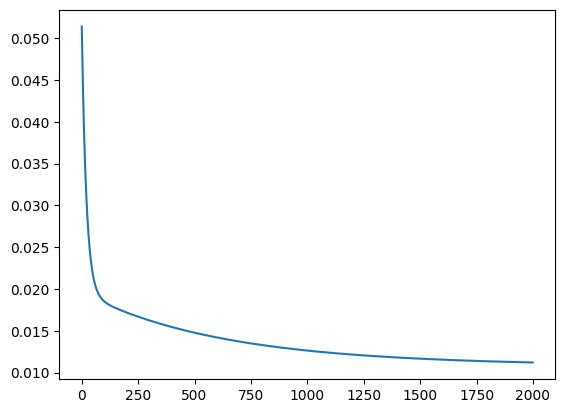

In [19]:
# Define gradient computation function
def grad(prediction, target, input):
    """ Gradient function
    Args:
        prediction: column vector of predictions, 2d-array with shape (# samples, 1)
        target: column vector of ground truths, 2d-array with shape (# samples, 1)
        input: feature matrix, 2d-array with shape (# samples, # features)
    Returns:
        dw: row vector of MSE loss partial derivatives w.r.t. weights, 2d-array with shape (1, # features)
        db: scalar of MSE loss partial derivatives w.r.t. bias
    """
    dw = 1 / target.shape[0] * np.dot((prediction - target).T, input)  # dL/dw
    db = (prediction - target).mean()  # dL/db
    
    return dw, db

# Gradient descent optimization
num_iters = 2000
learning_rate = 0.02
losses = []
for i in range(num_iters):
    y_pred = forward(X_train, w, b)
    dw, db = grad(y_pred, y_train, X_train)
    loss = mse_loss(y_pred, y_train)
    w = w - learning_rate * dw
    b = b - learning_rate * db
    print(f"loss @ {i+1} iteration: {loss}")
    # print(f"w = {w}, b = {b}")
    losses.append(loss)
print(f"updated w={w}, b={b}")

# Observe the loss change
plt.plot(losses)

## Assess Model on Training Data
Now, we can use the updated model with **updated** $w_1$, $w_2$ and $b$ to predict car prices.

[Text(0.5, 0, 'Mileage (Unit: 267334.0 miles)'),
 Text(0, 0.5, 'Price (Unit: $64997)')]

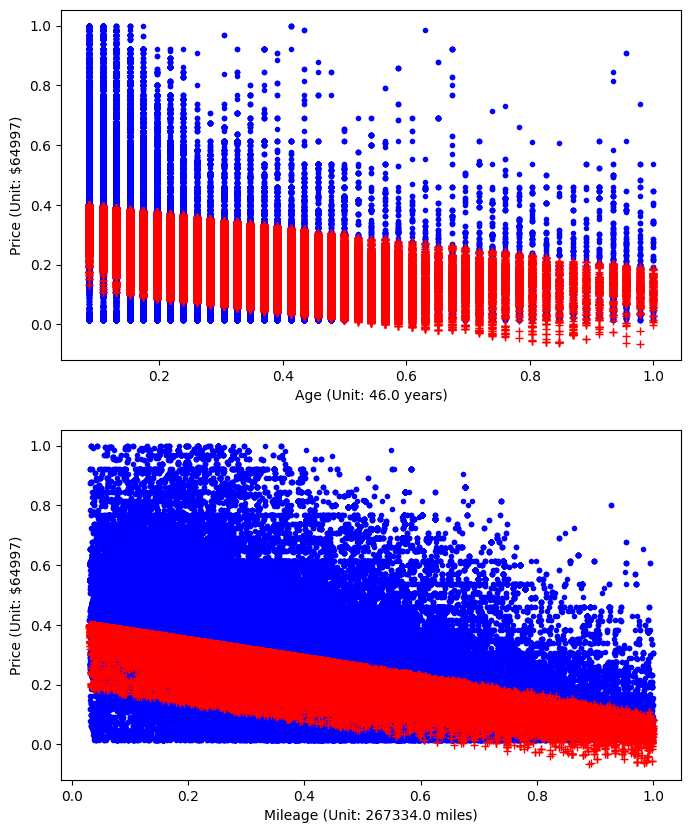

In [20]:
# Visualize model on training data
fig, axs = plt.subplots(2,1)  # Initialize figures in 2 rows, 1 column
fig.set_figwidth(8)  # set figure size
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)  # plot in the first figure
axs[0].plot(X_train[:, 0], y_train, 'b.')  # draw blue dots
axs[0].plot(X_train[:, 0], y_pred, 'r+')  # draw red '+' markers
axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')  # label axes
axs[1] = plt.subplot(2,1,2)
axs[1].plot(X_train[:, 1], y_train, 'b.')
axs[1].plot(X_train[:, 1], y_pred, 'r+')
axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')

### Assess Model on Test Data

Model's mse on test data: 0.011566689545865474


[Text(0.5, 0, 'Mileage (Unit: 267334.0 miles)'),
 Text(0, 0.5, 'Price (Unit: $64997)')]

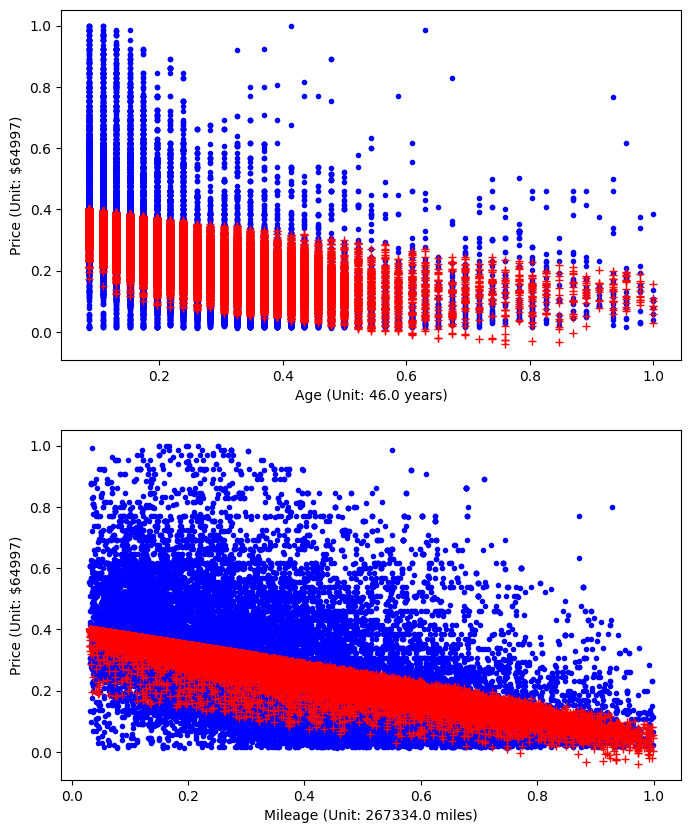

In [21]:
# Compute MSE
print(f"Model's mse on test data: {mse_loss(forward(X_test, w, b), y_test)}")

# Visualization
y_test_pred = forward(X_test, w, b)
fig, axs = plt.subplots(2,1)
fig.set_figwidth(8)
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)
axs[0].plot(X_test[:, 0], y_test, 'b.')
axs[0].plot(X_test[:, 0], y_test_pred, 'r+')
axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')
axs[1] = plt.subplot(2,1,2)
axs[1].plot(X_test[:, 1], y_test, 'b.')
axs[1].plot(X_test[:, 1], y_test_pred, 'r+')
axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')

## Train a Model with a Single Feature
Is model trained with two-feature data (`X_train`) better than the model trained with only one feature (`X_train[:, 0]` or `X_train[:, 1]`)?

loss @ 1 iteration: 0.05137624909242686
loss @ 2 iteration: 0.049934596562902604
loss @ 3 iteration: 0.04855499703905873
loss @ 4 iteration: 0.04723477005578264
loss @ 5 iteration: 0.045971350919664714
loss @ 6 iteration: 0.04476228570927431
loss @ 7 iteration: 0.043605226491340264
loss @ 8 iteration: 0.04249792674351271
loss @ 9 iteration: 0.04143823697478565
loss @ 10 iteration: 0.0404241005350452
loss @ 11 iteration: 0.03945354960557613
loss @ 12 iteration: 0.03852470136271331
loss @ 13 iteration: 0.03763575430716086
loss @ 14 iteration: 0.03678498475182506
loss @ 15 iteration: 0.03597074346131669
loss @ 16 iteration: 0.03519145243657264
loss @ 17 iteration: 0.03444560183833072
loss @ 18 iteration: 0.03373174704346162
loss @ 19 iteration: 0.033048505828420865
loss @ 20 iteration: 0.03239455567433142
loss @ 21 iteration: 0.03176863118844477
loss @ 22 iteration: 0.031169521636954925
loss @ 23 iteration: 0.03059606858435682
loss @ 24 iteration: 0.03004716363474838
loss @ 25 iteration: 

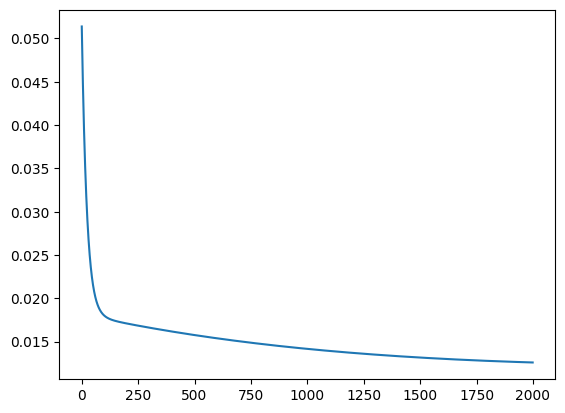

In [22]:
# Initialize model parameters: w1, b1
w = np.zeros((1, 1)) + np.random.normal(0, 1e-4, (1, 1)) 
b = 0 + np.random.normal(0, 1e-4)

# Train a model
num_iters = 2000
learning_rate = 0.02
losses = []
for i in range(num_iters):
    y_pred = forward(X_train[:, 0].reshape(-1, 1), w, b)
    dw, db = grad(y_pred, y_train, X_train[:, 1].reshape(-1, 1))
    loss = mse_loss(y_pred, y_train)
    w = w - learning_rate * dw
    b = b - learning_rate * db
    print(f"loss @ {i+1} iteration: {loss}")
    losses.append(loss)
print(f"updated w1={w}, b={b}")

# Observe loss values
plt.plot(losses)
print(f"Model's mse on test data: {mse_loss(forward(X_test[:, 0].reshape(-1, 1), w, b), y_test)}")


## Sigmoid Activation

loss @ 1 iteration: 0.045104147845280905
loss @ 2 iteration: 0.044966242707395986
loss @ 3 iteration: 0.04482896141053631
loss @ 4 iteration: 0.044692301868929064
loss @ 5 iteration: 0.04455626199146796
loss @ 6 iteration: 0.044420839681918234
loss @ 7 iteration: 0.04428603283911922
loss @ 8 iteration: 0.04415183935718513
loss @ 9 iteration: 0.04401825712570348
loss @ 10 iteration: 0.043885284029931595
loss @ 11 iteration: 0.04375291795099075
loss @ 12 iteration: 0.043621156766058496
loss @ 13 iteration: 0.0434899983485586
loss @ 14 iteration: 0.04335944056834907
loss @ 15 iteration: 0.043229481291907935
loss @ 16 iteration: 0.04310011838251699
loss @ 17 iteration: 0.04297134970044347
loss @ 18 iteration: 0.042843173103119525
loss @ 19 iteration: 0.04271558644531963
loss @ 20 iteration: 0.042588587579336055
loss @ 21 iteration: 0.04246217435515197
loss @ 22 iteration: 0.042336344620612726
loss @ 23 iteration: 0.04221109622159499
loss @ 24 iteration: 0.04208642700217363
loss @ 25 iterat

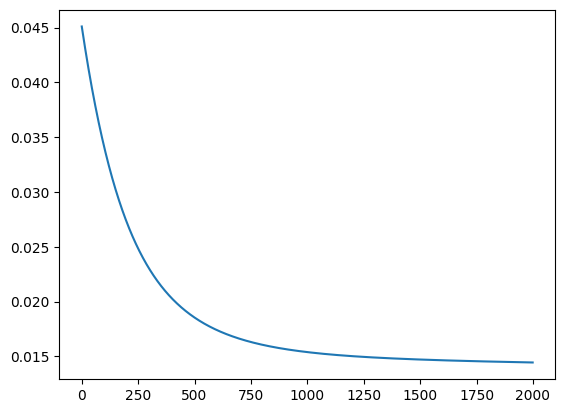

In [23]:
# Define ReLU function
def sigmoid(x):
    """ Sigmoid function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        y: dependent variable, could be an arrary of any shape or a scalar.
    """
    y = 1 / (1 + np.exp(-x))
    return y

# Define derivatives of ReLU function
def d_sigmoid(x):
    """ Derivative of sigmoid function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        dydx: dependent variable, could be an arrary of any shape or a scalar.
    """
    dydx = sigmoid(x) * (1 - sigmoid(x))
    return dydx

# Redefine forward pass. Intermediate result, Z, needs to be tracked 
def forward(input, weight, bias):
    """ Model function
    Args:
        input: feature matrix (independent variables), 2d-array with shape (# samples, # features)
        weight: row vector of weights, 2d-array with shape (1, # features)
        bias: scalar
    Returns:
        output: column vector of predictions (sigmoid activated outcomes), 2d-array with shape (# samples, 1)
        Z: column vector of intermediate outputs, 2d-array with shape (# samples, 1)
    """
    Z = np.dot(input, weight.T) + bias
    output = sigmoid(Z)
    return output, Z

# Redefine gradient function. An exatra step to calculate dL/dZ will be added. 
def grad(prediction, target, Z, input):
    """ Gradient function with sigmoid activation
    Args:
        prediction: column vector of predictions, 2d-array with shape (# samples, 1)
        target: column vector of ground truths, 2d-array with shape (# samples, 1)
        Z: column vector of intermediate outputs, 2d-array with shape (# samples, 1)
        feature: feature matrix, 2d-array with shape (# samples, # features)
    Returns:
        dw: row vector of MSE loss partial derivatives w.r.t. weights, 2d-array with shape (1, # features)
        db: scalar of MSE loss partial derivatives w.r.t. bias
    """
    dZ = (prediction - target) * d_sigmoid(Z)
    dw = 1 / target.shape[0] * np.dot(dZ.T, input)
    db = dZ.mean()
    
    return dw, db

# Optimization with ReLU activation
w = np.zeros((1, 2)) + np.random.normal(0, 1e-4, (1, 2)) 
b = 0 + np.random.normal(0, 1e-4)
num_iters = 2000
learning_rate = 0.03
losses = []
for i in range(num_iters):
    y_pred, Z = forward(X_train, w, b)
    dw, db = grad(y_pred, y_train, Z, X_train)
    loss = mse_loss(y_pred, y_train)
    w = w - learning_rate * dw
    b = b - learning_rate * db
    print(f"loss @ {i+1} iteration: {loss}")
    # print(f"w = {w}, b = {b}")
    losses.append(loss)
print(f"updated w={w}, b={b}")
print(f"Model's mse on test data: {mse_loss(forward(X_test, w, b), y_test)}")

# Observe loss values
plt.plot(losses)

## Test Sigmoid Activated Model

Model's mse on test data: 0.01487647076508446


[Text(0.5, 0, 'Mileage (Unit: 267334.0 miles)'),
 Text(0, 0.5, 'Price (Unit: $64997)')]

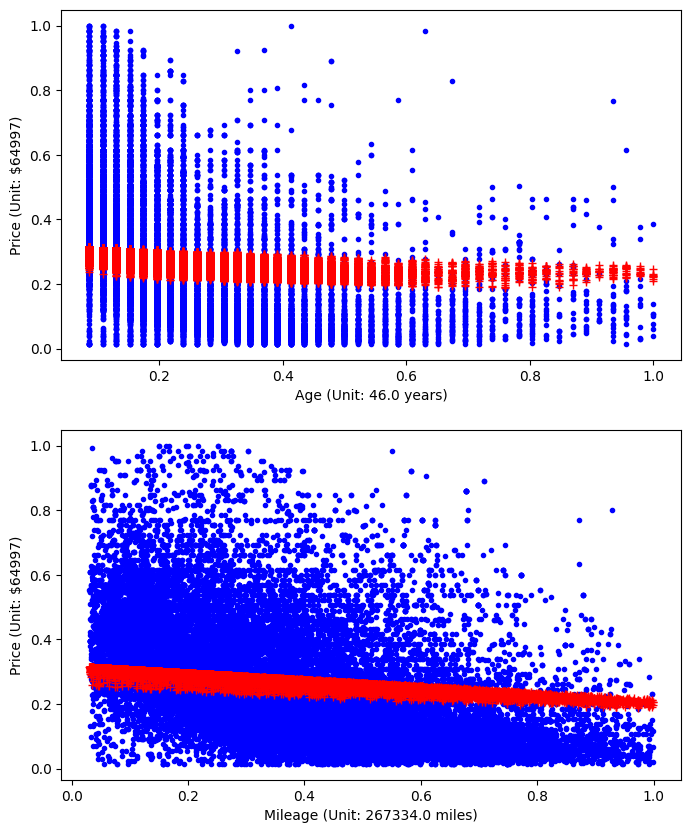

In [24]:
y_test_pred, _ = forward(X_test, w, b)
print(f"Model's mse on test data: {mse_loss(y_test_pred, y_test)}")

# Visualize model on two dimensions
fig, axs = plt.subplots(2,1)
fig.set_figwidth(8)
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)
axs[0].plot(X_test[:, 0], y_test, 'b.')
axs[0].plot(X_test[:, 0], y_test_pred, 'r+')
axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')
axs[1] = plt.subplot(2,1,2)
axs[1].plot(X_test[:, 1], y_test, 'b.')
axs[1].plot(X_test[:, 1], y_test_pred, 'r+')
axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')

## ReLU Activation
Negative car price does not make sense. The output needs to be regulated to only output non-negative value.

loss @ 1 iteration: 0.051355141575190506
loss @ 2 iteration: 0.05105398518204716
loss @ 3 iteration: 0.04953229781850482
loss @ 4 iteration: 0.04808281968104431
loss @ 5 iteration: 0.04670209445234126
loss @ 6 iteration: 0.045386831301854696
loss @ 7 iteration: 0.044133896962319605
loss @ 8 iteration: 0.042940308185617185
loss @ 9 iteration: 0.041803224559857854
loss @ 10 iteration: 0.040719941670382946
loss @ 11 iteration: 0.03968788458821744
loss @ 12 iteration: 0.038704601670295664
loss @ 13 iteration: 0.037767758656532556
loss @ 14 iteration: 0.03687513304952714
loss @ 15 iteration: 0.036024608763365794
loss @ 16 iteration: 0.03521417102864115
loss @ 17 iteration: 0.034441901541418504
loss @ 18 iteration: 0.03370597384447011
loss @ 19 iteration: 0.0330046489296558
loss @ 20 iteration: 0.0323362710508619
loss @ 21 iteration: 0.031699263737416536
loss @ 22 iteration: 0.03109212599838281
loss @ 23 iteration: 0.03051342870859044
loss @ 24 iteration: 0.02996181116770433
loss @ 25 iterat

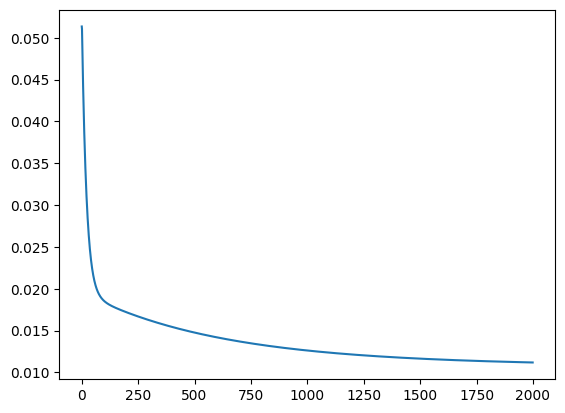

In [25]:
# Define ReLU function
def relu(x):
    """ ReLU function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        y: dependent variable, could be an arrary of any shape or a scalar.
    """
    # y = x.copy()
    y = x
    y[x<=0] = 0
    return y

# Define derivatives of ReLU function
def d_relu(x):
    """ Derivative of ReLU function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        dydx: dependent variable, could be an arrary of any shape or a scalar.
    """
    dydx = np.zeros_like(x)
    dydx[x>0] = 1
    return dydx

# Redefine forward pass. Intermediate result, Z, needs to be tracked 
def forward(input, weight, bias):
    """ Model function
    Args:
        input: feature matrix (independent variables), 2d-array with shape (# samples, # features)
        weight: row vector of weights, 2d-array with shape (1, # features)
        bias: scalar
    Returns:
        output: column vector of predictions (sigmoid activated outcomes), 2d-array with shape (# samples, 1)
        Z: column vector of intermediate outputs, 2d-array with shape (# samples, 1)
    """
    Z = np.dot(input, weight.T) + bias
    output = relu(Z)
    return output, Z

# Redefine gradient function. An exatra step to calculate dL/dZ will be added. 
def grad(prediction, target, Z, input):
    """ Gradient function with sigmoid activation
    Args:
        prediction: column vector of predictions, 2d-array with shape (# samples, 1)
        target: column vector of ground truths, 2d-array with shape (# samples, 1)
        Z: column vector of intermediate outputs, 2d-array with shape (# samples, 1)
        feature: feature matrix, 2d-array with shape (# samples, # features)
    Returns:
        dw: row vector of MSE loss partial derivatives w.r.t. weights, 2d-array with shape (1, # features)
        db: scalar of MSE loss partial derivatives w.r.t. bias
    """
    dZ = (prediction - target) * d_relu(Z)
    dw = 1 / target.shape[0] * np.dot(dZ.T, input)
    db = dZ.mean()
    
    return dw, db

# Optimization with ReLU activation
w = np.zeros((1, 2)) + np.random.normal(0, 1e-4, (1, 2)) 
b = 0 + np.random.normal(0, 1e-4)
num_iters = 2000
learning_rate = 0.02
losses = []
for i in range(num_iters):
    y_pred, Z = forward(X_train, w, b)
    dw, db = grad(y_pred, y_train, Z, X_train)
    loss = mse_loss(y_pred, y_train)
    w = w - learning_rate * dw
    b = b - learning_rate * db
    print(f"loss @ {i+1} iteration: {loss}")
    # print(f"w = {w}, b = {b}")
    losses.append(loss)
print(f"updated w={w}, b={b}")
print(f"Model's mse on test data: {mse_loss(forward(X_test, w, b), y_test)}")

# Observe loss values
plt.plot(losses)

## Visualize ReLU Activated Model

Model's mse on test data: 0.011564739917601046


[Text(0.5, 0, 'Mileage (Unit: 267334.0 miles)'),
 Text(0, 0.5, 'Price (Unit: $64997)')]

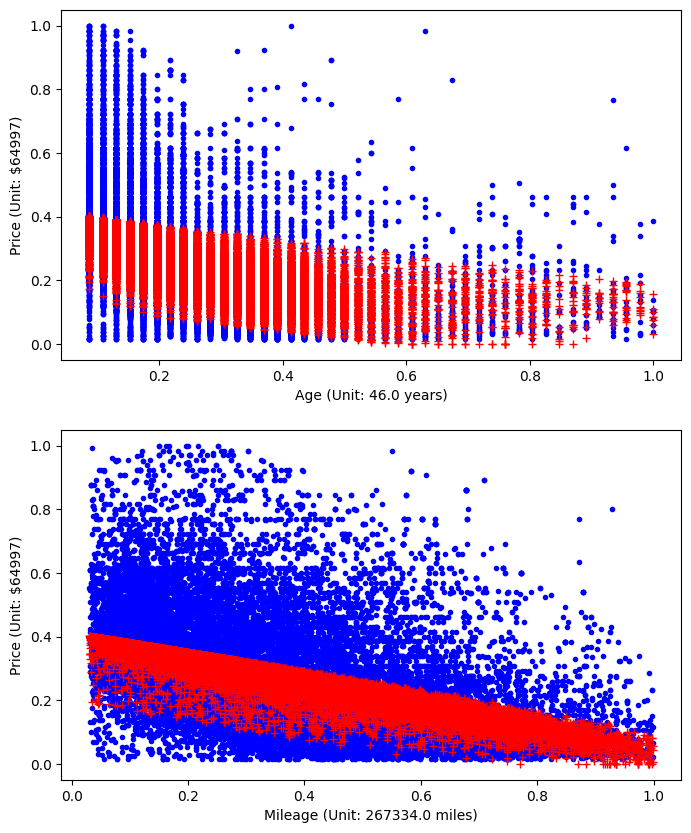

In [26]:
y_test_pred, _ = forward(X_test, w, b)
print(f"Model's mse on test data: {mse_loss(y_test_pred, y_test)}")

# Visualize model on two dimensions
y_test_pred, _ = forward(X_test, w, b)
fig, axs = plt.subplots(2,1)
fig.set_figwidth(8)
fig.set_figheight(10)
axs[0] = plt.subplot(2,1,1)
axs[0].plot(X_test[:, 0], y_test, 'b.')
axs[0].plot(X_test[:, 0], y_test_pred, 'r+')
axs[0].set(xlabel=f'Age (Unit: {age_train.max()} years)', ylabel=f'Price (Unit: ${price_train.max()})')
axs[1] = plt.subplot(2,1,2)
axs[1].plot(X_test[:, 1], y_test, 'b.')
axs[1].plot(X_test[:, 1], y_test_pred, 'r+')
axs[1].set(xlabel=f'Mileage (Unit: {mileage_train.max()} miles)', ylabel=f'Price (Unit: ${price_train.max()})')

## 